 ## Imports

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import pickle
from xgboost import XGBClassifier, plot_importance
import random
from IPython.display import display

In [3]:
titanic = pd.read_csv('Projects/Titanic Kaggle Competition/train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic.shape

(891, 12)

In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB



 ## Preprocessing

 First of all, we will drop the `name` and `ticket` columns, as the unique entries will not help us with our predictions.

In [6]:
titanic = titanic.drop(columns=['Name', 'Ticket'])
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S



Normally, we will also drop the `Sex` column as to avoid to make predictions based on gender. However, this specific case require us to use the `Sex` column, due to the famed philosophy of 'Women and children first' that is usually employed when disasters strike.

 Next, we will check for missing values.

In [7]:
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         2
dtype: int64


 We have missing values on the `Age`, `Cabin` and `Embarked` columns. We will have to deal with these missing values differently for each column:
 
 # Write treatment for age NAs
 
 `Age`: Due to the importance of getting these values right, we will 
 
 `Cabin`: The majority of passengers in this dataframe do not have a Cabin number listed. We could trace down the names and cross reference with the original manifest from the ill-fated ship, but in the interest for simplicity we will drop this column altogether.
 
 `Embarked`: We only have 2 missing values in this column. The nature for the null values could be human error when populating this dataset, or possible stowaways not included in the original manifest, but later included in the list of people travelling on the ship. For this column, we will check for the number of people that embarked on each port, and using a random number generator we will assign a port of embarkment to both the passengers with missing values.

In [8]:
titanic = titanic.drop(columns=['Cabin'])
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [9]:
titanic[titanic['Embarked'].isna()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,62,1,1,female,38.0,0,0,80.0,NaN
829,830,1,1,female,62.0,0,0,80.0,NaN


In [10]:
titanic['Embarked'].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64


 We will get a random number for each passenger and the result will dictate their inclusion into an embarkment port. 
 
 If the number is 0 < x < 0.724409, the passenger will be given the embarkment port S. 
 
 If the number is 0.724409 < x < 0.913385, the passenger will be given the embarkment port C. 
 
 Finally, if the number is 0.913385 < x < 1, the passenger will be given the embarkment port Q.

In [11]:
def get_random_number():
    random_number = random.uniform(0, 1)
    return random_number
print(f'Random number for first passenger:{get_random_number()}')
print(f'Random number for second passenger:{get_random_number()}')

Random number for first passenger:0.018492300411474316
Random number for second passenger:0.3504605648601571



Given the results of our random number, we will assign both passengers to the S embarkment port.

In [12]:
titanic.loc[61, 'Embarked'] = 'S'
titanic.loc[829, 'Embarked'] = 'S'


 Now, dealing with the `age` missing values is the trickiest of the three, given the number of missing values and the importance of the `age` column in predicting if a particular passenger survived or not.

 Let's plot the distribution of age in the Titanic:

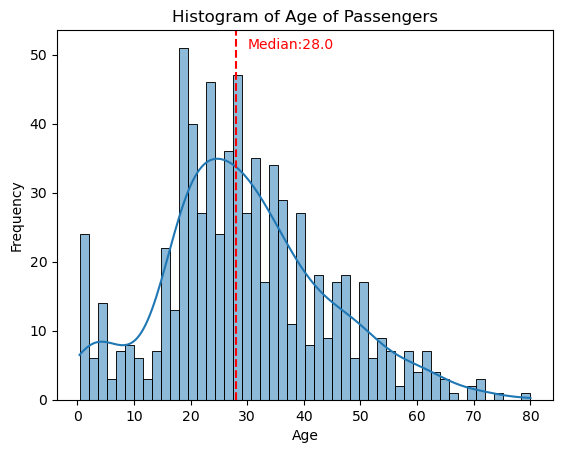

In [13]:
sns.histplot(titanic['Age'], bins=50, kde=True)
plt.axvline(x=titanic['Age'].median(), linestyle='--', color='red')
plt.text(titanic['Age'].median() + 2, 0.95 * plt.ylim()[1], f'Median:{round(titanic["Age"].median(), 2)}', color='red')
plt.ylabel('Frequency')
plt.title('Histogram of Age of Passengers');


 We can see that the distribution is Right-Skewed, with a median of 28. 

 Let's see if we can find some patterns in the `age` variable with the other variables

In [14]:
pivot_table = pd.pivot_table(titanic,
                             values='Age',
                             index=['Embarked', 'Pclass', 'Survived', 'Sex'],
                             aggfunc=np.nanmean)
display(pivot_table)

Age
Embarked Pclass Survived Sex              
C        1      0        female  50.000000
                         male    43.050000
                1        female  35.675676
                         male    36.437500
         2      0        male    29.500000
                1        female  19.142857
                         male     1.000000
         3      0        female  20.700000
                         male    27.555556
                1        female  11.045455
                         male    18.488571
Q        1      0        male    44.000000
                1        female  33.000000
         2      0        male    57.000000
                1        female  30.000000
         3      0        female  28.100000
                         male    28.076923
                1        female  17.600000
                         male    29.000000
S        1      0        female  13.500000
                         male    45.362500
                1        female  34.363636
                         male    36.121667
         2      0        female  36.000000
                         male    33.414474
                1        female  29.091667
                         male    17.095000
         3      0        female  23.688889
                         male    27.168478
                1        female  22.548387
                         male    22.933333


 Across all Classes and all Embarkment ports, we can see that the average age of those who survived is smaller than the average age of those who perished. Also, as `Class` decreases (e.g. from 1 to 2), average age tends to decrease as well.
 
 This can be useful when addressing the missing values in the `Age`column. 
 

In [15]:
age_by_sex = titanic.dropna(subset=['Age']).groupby(['Sex', 'Survived'])['Age'].mean()
age_by_sex = pd.DataFrame(age_by_sex)
age_by_sex

Age
Sex    Survived           
female 0         25.046875
       1         28.847716
male   0         31.618056
       1         27.276022


 When we check for the average age of those who survived grouped by `Sex` we get something interesting. In average, the age of females who survived is greater than the females who perished. However, the average age of males who survived is smaller than those who perished. 

 It seems that the best course of action to replace the missing values would be to identify the passenger's port of embarkment, class and if they survived, retrieve the average age for those parameters and get the average between that value and the average age of the relevant gender.
 

In [16]:
missing = titanic[titanic['Age'].isna()].reset_index()

In [17]:
titanic_no_missing = titanic.dropna(subset=['Age'])

In [18]:
def get_mean_age(row, pivot_table):
    return pivot_table.loc[(row['Embarked'], row['Pclass'], row['Survived'], row['Sex'])]

In [19]:
missing['Age'] = missing.apply(lambda row: get_mean_age(row, pivot_table), axis=1)

In [20]:
missing.head()

,index,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,5,6,0,3,male,28.076923,0,0,8.4583,Q
1,17,18,1,2,male,17.095000,0,0,13.0000,S
2,19,20,1,3,female,11.045455,0,0,7.2250,C
3,26,27,0,3,male,27.555556,0,0,7.2250,C
4,28,29,1,3,female,17.600000,0,0,7.8792,Q


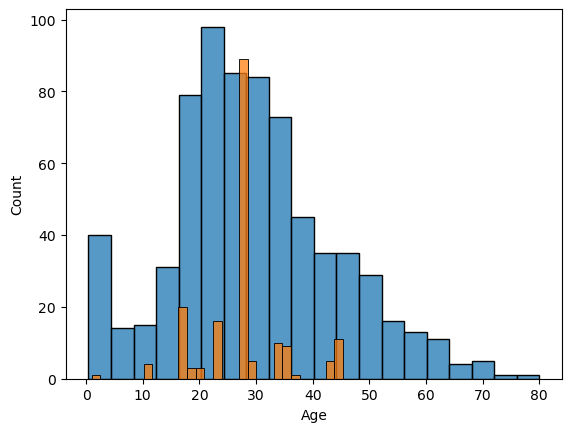

In [21]:
sns.histplot(titanic_no_missing['Age'])
sns.histplot(missing['Age'])
plt.show()

In [22]:
titanic = pd.concat([titanic_no_missing, missing])

In [23]:
titanic.drop('index', axis=1, inplace=True)

In [24]:
titanic['Age'].describe()

count    891.000000
mean      29.292509
std       13.463334
min        0.420000
25%       21.000000
50%       27.555556
75%       36.000000
max       80.000000
Name: Age, dtype: float64

In [25]:
titanic_dummies = pd.get_dummies(titanic,
                                 columns=['Sex', 'Embarked'])


 Now that we have replaced the missing values of the `Age` variable, we are ready to begin training our model. We will first proceed with the Random Forest model.
 
 Firstly, we need to separate our dataframe into independent and dependent variables, and then split them into training and testing groups.

In [26]:
X = titanic_dummies.drop('Survived', axis=1)
y = titanic_dummies['Survived']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)


 Now, we will set our GridSearch to find the best parameters for this model.

In [34]:
cv_params = {'n_estimators': [100, 200, 500],
             'max_depth': [10, 20, 30, None],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4]}

In [35]:
rf = RandomForestClassifier(random_state=42)

In [36]:
cv_rf = GridSearchCV(estimator=rf, param_grid=cv_params, cv=5, n_jobs=-1, scoring='accuracy')

In [63]:
cv_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy')

In [64]:
cv_rf.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}


 Now, we can train our model using the best hyperparameters we found.

In [38]:
rf_opt = RandomForestClassifier(n_estimators=500, min_samples_leaf=1, min_samples_split=2, max_depth=20)

In [39]:
rf_opt.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=500)

In [40]:
y_pred = rf_opt.predict(X_test)


 Now, we will create a new dataframe, so we can compare the performance metrics of our models.

In [41]:
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

In [42]:
def get_scores(test, preds, results, model):
    ''' Receives: 
        - y_test
        - y_pred
        - Results DataFrame
        - The name of the model
        
        Returns:
        - The results DataFrame with the performance metrics for the model selected
    '''
    model = model
    accuracy = metrics.accuracy_score(test, preds)
    precision = metrics.precision_score(test, preds)
    recall = metrics.recall_score(test, preds)
    f1 = metrics.f1_score(test, preds)
    
    new_results = pd.DataFrame([[model, accuracy, precision, recall, f1]], columns=['Model', 'Accuracy',
                                                                                    'Precision', 'Recall',
                                                                                    'F1'])
    results = pd.concat([results, new_results], ignore_index=True)
    
    return results
    
    
    

In [43]:
results = get_scores(y_test, y_pred, results, 'Random Forest')
results

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.825112,0.790123,0.744186,0.766467



 The performance metrics for the Random Forest model are quite good. Let's see if we can enhance this scores using a Gradient Booster model.

First, we will split the data and set a range of hyperparameters to find the optimal ones using GridSearch

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [45]:
xgb_params = {'n_estimators': [100, 200, 300],
              'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [3, 5, 7],
              'min_child_weight': [1, 3, 5],
              'gamma': [0, 0.1, 0.2],
              'subsample': [0.7, 0.8, 0.9],
              'colsample_bytree': [0.7, 0.8, 0.9],
              'reg_alpha': [0, 0.1, 1],
              'reg_lambda': [1, 1.1, 1.2]}

In [46]:
xgb = XGBClassifier(random_state=42)

In [47]:
cv_xgb = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=5, n_jobs=-1, scoring='accuracy')

In [48]:
with open('grid_search_xgb.pkl', 'wb') as file:
    pickle.dump(cv_xgb, file)

In [65]:
cv_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'reg_alpha': [0, 0.1, 1], 'reg_lambda': [1, 1.1, 1.2],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy')

In [66]:
cv_xgb.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 100,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'subsample': 0.7}

In [50]:
xgb_opt = XGBClassifier(colsample_bytree=0.7, gamma=0, learning_rate=0.05,
                        max_depth=7, min_child_weight=1, n_estimators=100,
                        reg_alpha=0, reg_lambda=1, subsample=0.7, random_state=42)

In [51]:
xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [52]:
y_preds = xgb_opt.predict(X_test)

In [53]:
results = get_scores(y_test, y_preds, results, 'XGBoost')
results

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.825112,0.790123,0.744186,0.766467
1,XGBoost,0.825112,0.797468,0.732558,0.763636


 Finally, we will import Kaggle's test data for our submission.

In [54]:
X_test_kaggle = pd.read_csv('Projects/Titanic Kaggle Competition/test.csv')

In [55]:
X_test_kaggle.drop(columns=['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
X_test_kaggle = pd.get_dummies(X_test_kaggle, columns=['Sex', 'Embarked'])
X_test_kaggle.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,0,1,0,1,0
1,893,3,47.0,1,0,7.0000,1,0,0,0,1
2,894,2,62.0,0,0,9.6875,0,1,0,1,0
3,895,3,27.0,0,0,8.6625,0,1,0,0,1
4,896,3,22.0,1,1,12.2875,1,0,0,0,1


In [56]:
y_preds_kaggle = xgb_opt.predict(X_test_kaggle)

In [57]:
survived = pd.Series(y_preds_kaggle)

In [58]:
submission = pd.DataFrame(X_test_kaggle['PassengerId'])

In [59]:
submission['Survived'] = survived

In [60]:
submission.to_csv('Projects/Titanic Kaggle Competition/Submission.csv', index=False)